## Colour detection

1. Load the dataset images
2. For each dataset image, crop out the card
3. Split the dataset into training and testing (80% / 20%)
4. For the training dataset, does the color detection
   * Resize the image to a very small image using NEAREST interpolation
   * Do a k-means (K=2) to find white color and uno card color
   * Pick color which is farthest from white, should pick uno color
   * Transform color to HSV and pick hue as dominant color
5. For the test dataset, test against the training dataset
   * Find dominant color as explained above
   * Compare dominant color with train dataset dominant color
   * Pick closest hue value in train dataset
   * Make sure that train and test label for color match

In [10]:
import glob
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import random

### 1. Load dataset

Load the images found in `CARDS/*`. Also analyze the filename to extract the label for each image.

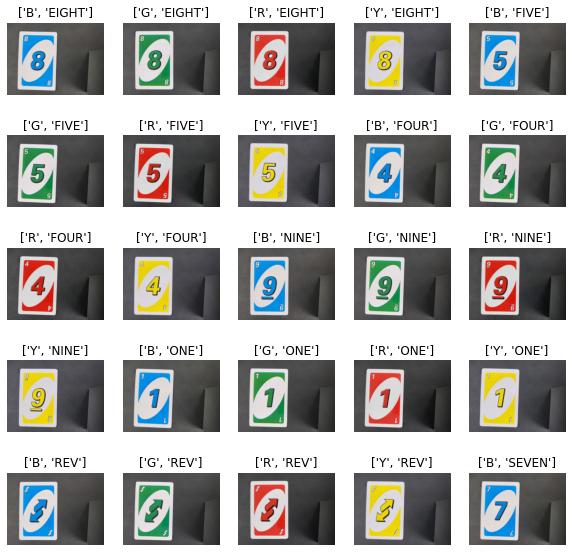

In [11]:
# Load dataset
images = []
labels = []

for fn in glob.glob("CARDS/*"): # CARDS is the name of the UNO cards folder.
  # Load image
  img = cv.imread(fn)
  images.append(img)

  # Parse image filename for label
  bname = os.path.basename(fn) # only get filename ( remove directory path )
  rname, _ = os.path.splitext(bname) # remove extension

  # Example names:
  #  * ZERO_B
  #  * TWO_B_DRAW
  #  * SKIP_Y
  # 
  # The second part is the color (R,G,B,Y)
  # rest is number (or special)
  name_parts = rname.split("_")
  color = name_parts[1]
  label = "_".join([name_parts[0]]+name_parts[2:])

  # Now color is R,G,B,Y
  # label is ZERO, TWO_DRAW, SKIP, ...
  labels.append([color, label])

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  # Last indices is the reverse BGR to RGB
  # Opencv works in BGR, matplotlib need to display in RGB
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### 2. Crop out card

An edge detection is performed to find the cards in the image. This is done with an adaptive threshold with is the best method to have a fast and lighting robust edge detection. Then any external contour is picked as potential card contour. The inner contour is picked as the card contour. This contour must also have a minimal area so that noise is not picked up. The contour is approximated with an oriented bounding box (OBB). The four corner points are then used to perform a perspective transform, to reorient and crop the card image.

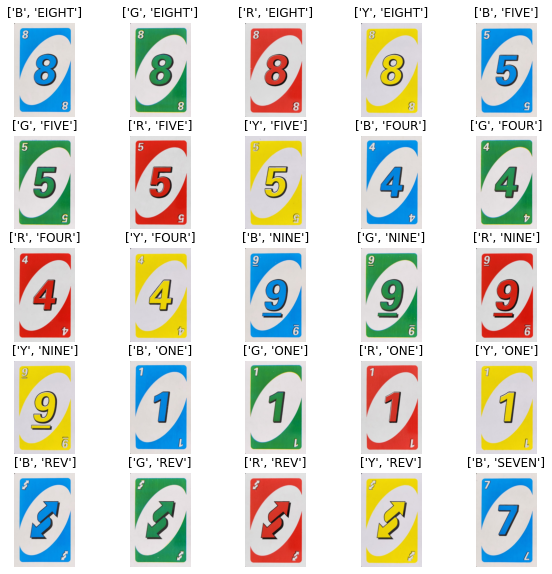

In [12]:
# Find region of interest (ROI) for each image
for i in range(len(images)):
  # Do adaptive threshold to find edges
  # Apply a gaussian blur just before to 
  # make sure it doesn't pick up noisy edges
  gray = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (21, 21), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  

  # After getting two contours
  # Pick the most inner one.
  # Do dilatation process
 
  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel, iterations=10)

  # Find biggest external contour which is 
  # quadrilatel like
  contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  idx_biggest = np.argmax([cv.contourArea(c) for c in contours])
  idx_inner = hierarchy[0][idx_biggest][2]
  cnt = contours[idx_inner]

  # cv.drawContours(images[i], contours, -1, (0, 0, 255), 2)
  # cv.drawContours(images[i], contours, idx_inner, (0, 0, 255), 2)

  # Find oriented bounding box around card
  rect = cv.minAreaRect(cnt)
  box = cv.boxPoints(rect)

  # Have the most top-left first, and also 
  # the contour should be clockwise from the 
  # previous functions
  idx_leftop = np.argmin([p[0]+p[1] for p in box])
  box_ordered = []
  for j in range(4):
    box_ordered.append(box[(idx_leftop+j)%4])
  box = np.array(box_ordered)


  # cv.drawContours(images[i], [box], 0, (0, 0, 255), 2)
  # plt.imshow(images[i])
  # plt.show()

  # Estimate card width and height

  #   [0]   l11   [1]
  #     ┌────────┐
  #     │        │
  # l22 │        │ l21
  #     │        │
  #     │        │
  #     └────────┘
  #   [3]   l12   [2]

  box_l11 = np.linalg.norm(box[0]-box[1])
  box_l12 = np.linalg.norm(box[2]-box[3])

  box_l21 = np.linalg.norm(box[1]-box[2])
  box_l22 = np.linalg.norm(box[3]-box[0])

  box_l1 = (box_l11+box_l12)/2
  box_l2 = (box_l21+box_l22)/2

  # Card is straight
  new_width, new_height = None, None
  if box_l1 < box_l2:
    new_points = np.array([
      [0, 0], [box_l1, 0], [box_l1, box_l2], [0, box_l2]])
    new_width = box_l1
    new_height = box_l2

  # Card is on its side
  else:
    new_points = np.array([[box_l2, 0], [box_l2, box_l1], [0, box_l1], [0, 0]])
    new_width = box_l2
    new_height = box_l1

  # Compute perspective transform matrix and get wrapped
  # image which is only the card
  M = cv.getPerspectiveTransform(np.float32(box), np.float32(new_points))
  roi = cv.warpPerspective(images[i], M, (round(new_width), round(new_height)))

  images[i] = roi

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### 3. Split the dataset into training and testing

Split the dataset into training and testing. Ideally, we would have 70%/30% but this could be too much where a single color is only in testing, thus a ratio of 80% / 20% is picked to be safe.

In [13]:
# Do testing for color
# Take a 80% train and 20% test proporition
indices = list(range(len(images)))
random.shuffle(indices)

train_indices = indices[:int(len(images)*0.8)]
test_indices = indices[int(len(images)*0.8):]

print("TRAIN: ", train_indices)
print("TEST: ", test_indices)

TRAIN:  [27, 51, 39, 12, 22, 10, 24, 45, 48, 8, 49, 35, 19, 34, 25, 31, 41, 36, 42, 21, 23, 9, 3, 32, 2, 14, 28, 47, 50, 37, 1, 43, 46, 7, 4, 33, 16, 30, 20, 0, 17]
TEST:  [15, 40, 18, 44, 11, 6, 13, 38, 29, 5, 26]


### 4. Color detection on training

#### 4.1 Resize image

The resizing is mainly done for speed up. K-means which is used afterwards is slow and we should avoid processing too big images. It is important to choose NEAREST interpolation so that colors are not mixed when downsizing.

Resize it to have a width of 10.

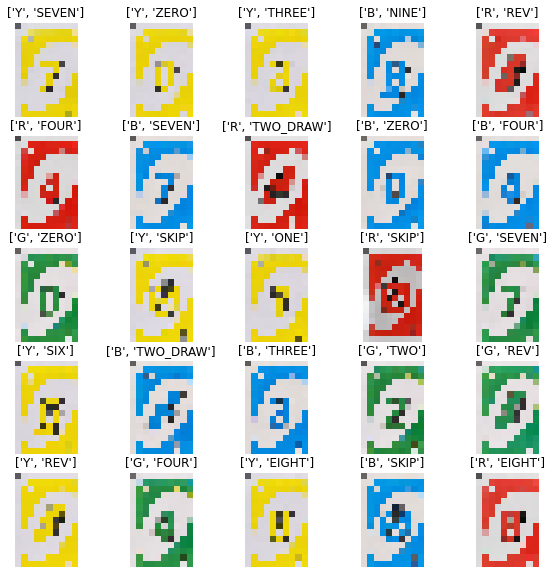

In [14]:
train_images = []

for i in train_indices:
  fxy = 10/images[i].shape[1]
  small = cv.resize(images[i], None, fx=fxy, fy=fxy, interpolation=cv.INTER_NEAREST)
  train_images.append(small)

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))

#### 4.2 Apply k-means 

First the image is reshaped into a single column vector, where each component is the color of a pixel. Then apply k-means to find 2 centers. The images should only have the color white, and the UNO color.

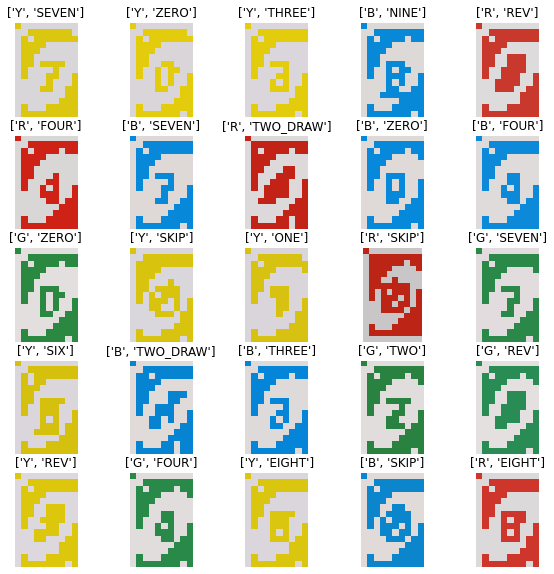

In [15]:
kmeans_result = []
dominant_colors = []

for ii, i in enumerate(train_indices):
  # Apply k-means with k = 2
  Z = train_images[ii].reshape((-1,3))
  Z = np.float32(Z)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
  idx_dominant = np.argmax([np.linalg.norm(c - np.array([255, 255, 255])) for c in center])
  dominant_color = center[idx_dominant]
  dominant_colors.append(dominant_color)
  
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((train_images[ii].shape))

  kmeans_result.append(res2)

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(kmeans_result[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))

#### 4.3 Find hue of dominant color

The color detection has to be robust against light changes. We choose here to pick the hue which is better than picking RGB directly.

In [16]:
for ii, i in enumerate(train_indices):
  dominant_color = cv.cvtColor(dominant_colors[ii][np.newaxis, np.newaxis, :], cv.COLOR_BGR2HSV)
  dominant_color = dominant_color[:,:,0]
  dominant_colors[ii] = dominant_color.flatten()[0]

for ii, i in enumerate(train_indices[:20]):
  print(labels[train_indices[ii]], dominant_colors[ii])

['Y', 'SEVEN'] 54.056293
['Y', 'ZERO'] 53.821693
['Y', 'THREE'] 53.904984
['B', 'NINE'] 202.5466
['R', 'REV'] 4.3262105
['R', 'FOUR'] 4.000993
['B', 'SEVEN'] 203.19803
['R', 'TWO_DRAW'] 4.176764
['B', 'ZERO'] 203.1218
['B', 'FOUR'] 203.6275
['G', 'ZERO'] 134.21434
['Y', 'SKIP'] 54.00246
['Y', 'ONE'] 53.685684
['R', 'SKIP'] 4.888229
['G', 'SEVEN'] 139.9708
['Y', 'SIX'] 53.62854
['B', 'TWO_DRAW'] 202.72482
['B', 'THREE'] 203.59865
['G', 'TWO'] 135.83855
['G', 'REV'] 146.70822


### 5. Test against testing data

Does the same step as the training data to find the dominant color. Then find the training data which has the closest dominant color and pick its label.

In [17]:
good, bad = 0, 0
for i in test_indices:
  fxy = 10/images[i].shape[1]
  small = cv.resize(images[i], None, fx=fxy, fy=fxy, interpolation=cv.INTER_NEAREST)

  # Apply k-means with k = 2
  Z = small.reshape((-1,3))
  Z = np.float32(Z)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

  idx_dominant = np.argmax([np.linalg.norm(c - np.array([255, 255, 255])) for c in center])
  dominant_color = center[idx_dominant]

  # Convert to HSV and extract hue
  dominant_color = cv.cvtColor(dominant_color[np.newaxis, np.newaxis, :], cv.COLOR_BGR2HSV)
  dominant_color = dominant_color[:,:,0]

  closest_idx = np.argmin([
    np.min([abs(dominant_color - dominant_colors[j]), abs((dominant_color+255) - dominant_colors[j]), abs(dominant_color - (dominant_colors[j]+255))])
    for j in range(len(train_indices))])


  closest_idx = train_indices[closest_idx]

  # Check that color match
  if labels[closest_idx][0] == labels[i][0]:
    good += 1
  else:
    bad += 1


print(f"Color testing: GOOD {good}/BAD {bad}/TOTAL {good+bad}")

Color testing: GOOD 11/BAD 0/TOTAL 11
